In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn import linear_model as lm
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
infile = 'master_county_datafile.csv'

In [2]:
# Create master DataFrame
data = pd.read_csv(infile)
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'county', 'state', 'county_and_state_x',
       'code', 'Deaths', 'Population', 'Crude Rate', 'fips', 'smoking',
       'obesity', 'foodenv', 'exercise', 'noinsurance', 'physicians',
       'pollution', 'diabetes', 'county_and_state_y', 'code2', 'sunlight',
       'blow', 'ganj', 'smack', 'Age Adjusted Rate', 'smoking_tr',
       'foodenv_tr', 'gauss_exercise', 'noinsurance_tr', 'physicians_tr'],
      dtype='object')

In [3]:
# A few things to remember:
#  Transforms:  (to generate normally distributed data)
#  smoking_tr = (smoking - 17.5) / 2.5 signed and raised to 0.75 power
#  foodenv_tr = foodenv / (15 - foodenv)
#  gauss_exercise = exercise ranked and transformed by noram dist cdf
#  noinsurance_tr = sqrt(noinsurance)
#  physicians_tr = log(physicians + 1)

# We will generate predicted values of the transformed parameters, so to recover
# the original parameters...
# Define the inverse transform functions

def inv_smoking (tr):
    return (np.sign(tr) * np.power(abs(tr),4/3)) * 2.5 + 17.5

def inv_foodenv (tr):
    return 15 * tr / (1.0 + tr)

def inv_noinsurance (tr):
    return tr * tr

def inv_physicians (tr):
    return exp(tr) - 1

# CAUTION: Doing the inverse of gexrank *requires* the global 'data' 
def inv_exercise (tr):
    return data.exercise.quantile(st.norm.cdf(tr),method='linear')

# Regression set-up

* We have nine county-level variables and three state-level variables -- one choice is whether to include
* We have the ability to use max data or eliminate all data with one missing parameter
* Our regression choices are "elastic net", "Ridge", "lasso", "partial least squares", "decision tree", "random forest", and "ordinary least squares"

### All factors only where all factors are present

In [4]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity','foodenv_tr','gauss_exercise','noinsurance_tr',
           'physicians_tr','pollution','diabetes','sunlight','blow','ganj','smack']
ymeasured = ['Crude Rate']
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

2804

In [5]:
# Do the train and test split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=42)
# Set up regression object
regr = lm.LinearRegression(normalize=True)
# Fit regression
regr.fit(Xtrain,Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [6]:
#Report coefficients and score
for a,b in zip(xfactors,regr.coef_):
    print(a,b)
print(f'intercept: {regr.intercept_}')

smoking_tr -5.594067607295691
obesity 0.32374956770343877
foodenv_tr -58.71264204595781
gauss_exercise 21.78341017112285
noinsurance_tr -52.96948455899125
physicians_tr -6.560477449406859
pollution -7.463384341851538
diabetes 15.996494258232216
sunlight -0.013183252079403232
blow -1.1864135158343503
ganj -0.34805499829778463
smack -92.19950111778886
intercept: 559.5246896070748


In [7]:
# Predict and score
regr.score(Xtest,Ytest)

0.26438010419032

##### How do we interpret the coefficients?  For each variable, this depends on our assumptions:

* For smoking, we have to consider both a personal effect, where the rate difference is the derivative of the inverse transformed value... however, we note that the transformation does not change values at 15% and 20% rates, so we can interpret the coefficient as half the effect of going from a 15% to a 20% rate.  So, in a simple "individual driven" model, the rate effect is 40 x the coefficient, in risk per year per 100,000.
* Obesity is not transformed, so in a "personal risk" model, the rate difference is 100 x the coefficient.  
* Diabetes is not transformed, so in a "personal risk" model, the rate difference is 100 x the coefficient.
* For blow, ganj, and smoke, the same rule applies...
* For physicians, the transform is a log, so the effect is what happens when multiplying your visits to the doctor by 10x
* For noinsurance_tr, the transform is the squart root, so the derivative is just the transformed derivative divided by 2 * the squared value of the mean transform, which is 2 * .326 * .326 = 0.212, so on a "personal level", the effect is 0.212 x the coefficient
* For environmental variables, we will use a "25th percentile to 75th percentile" measure, i.e, the effect of moving from a county in the 25th percentile to one in the 75th percentile.  Because the exercise is Gaussian transformed and ranked, we just need the z-scores for these percentiles (+ and - 0.674).  So, the effect is 1.349 x the coefficient, but inverted because a higher score gets a lower rank, so multiple the coefficient by -1.349
* For the remaining variables, we need the quartiles, they are:
* For foodenv_tr, 25th percentile = 0.851, 75th percentile = 1.206, so the effect is 0.349 x the coefficient
* For pollution, 25th = 7.7, 75th = 10.4, so the effect is 2.7 x the coefficient, but higher is worse, so use -2.7
* For sunlight, 25th = 14826.12, 75th = 17149.11, so the effect is 2323 x the coefficient

In [8]:
# Capture these results in an effects matrix
effects = np.array([40, 100, 0.349, -1.349, 0.212, 1, -2.7, 100, 2323, 100, 100, 100])

In [9]:
# Test parameter sensitivity to x-val selection
coeff = []
impacts = []
risks = []
intercepts = []
scores = []
for ix in range(100):
    # Do the train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
    # Set up regression object
    regr = lm.LinearRegression(normalize=True)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    coeff.append(regr.coef_)
    impacts.append(np.multiply(regr.coef_,effects))
    risks.append(np.multiply(regr.coef_,effects) / np.mean(Ytrain))
    intercepts.append(regr.intercept_)
    scores.append(regr.score(Xtest,Ytest))
ols_all_nona_df = pd.DataFrame(columns=xfactors,data=coeff)
ols_all_nona_df['Intercept'] = intercepts
ols_all_nona_df['Score'] = scores
ols_all_nona_df2 = pd.DataFrame(columns=xfactors,data=impacts)
ols_all_nona_df3 = pd.DataFrame(columns=xfactors,data=risks)

In [10]:
ols_all_nona_df.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack,Intercept,Score
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-8.410431,0.027424,-57.673474,22.927929,-48.259403,-6.545089,-8.370686,16.850264,-0.014159,-5.018239,-0.617105,-80.114145,587.719555,0.278332
std,2.034830,0.386899,5.740360,2.066734,23.729008,2.925914,0.787057,0.682629,0.001436,3.722538,0.626175,11.661300,31.015067,0.022049
min,-12.704235,-1.039362,-67.476164,17.691166,-104.137300,-12.150362,-10.360048,15.258541,-0.018375,-13.658335,-2.098021,-112.721592,505.010064,0.220980
25%,-9.748156,-0.207021,-61.840818,21.291128,-66.252393,-8.509192,-9.029536,16.345149,-0.014896,-7.531909,-0.934764,-85.868478,567.445789,0.265702
50%,-8.691493,0.012050,-58.754025,22.705087,-50.768218,-6.903635,-8.435899,16.941171,-0.014085,-5.458817,-0.509391,-79.022243,587.595208,0.273692
75%,-7.174074,0.302566,-54.003587,24.151733,-33.312117,-3.911489,-7.828365,17.345943,-0.013324,-2.692335,-0.275552,-74.328777,608.703884,0.291531
max,-2.165865,1.211676,-45.299052,28.374675,11.824371,-0.697623,-6.622628,18.725314,-0.011300,5.804851,0.957025,-56.391844,663.436999,0.332514


In [11]:
ols_all_nona_df2.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-336.417241,2.742402,-20.128042,-30.929776,-10.230993,-6.545089,22.600853,1685.026372,-32.891164,-501.823894,-61.710504,-8011.414536
std,81.393183,38.689869,2.003386,2.788024,5.030550,2.925914,2.125054,68.262932,3.336923,372.253820,62.617489,1166.130029
min,-508.169419,-103.936244,-23.549181,-38.277437,-22.077108,-12.150362,17.881094,1525.854056,-42.685073,-1365.833466,-209.802136,-11272.159245
25%,-389.926256,-20.702134,-21.582445,-32.580688,-14.045507,-8.509192,21.136584,1634.514860,-34.604500,-753.190944,-93.476405,-8586.847814
50%,-347.659701,1.205001,-20.505155,-30.629162,-10.762862,-6.903635,22.776928,1694.117082,-32.719500,-545.881658,-50.939150,-7902.224297
75%,-286.962971,30.256550,-18.847252,-28.721731,-7.062169,-3.911489,24.379746,1734.594264,-30.950610,-269.233510,-27.555207,-7432.877679
max,-86.634582,121.167551,-15.809369,-23.865383,2.506767,-0.697623,27.972129,1872.531375,-26.249675,580.485087,95.702465,-5639.184361


In [12]:
ols_all_nona_df3.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.994720,0.008146,-0.059517,-0.091462,-0.030255,-0.019352,0.066828,4.982827,-0.097262,-1.483489,-0.182510,-23.688401
std,0.240166,0.114392,0.005885,0.008233,0.014878,0.008648,0.006233,0.202038,0.009862,1.102393,0.185199,3.427770
min,-1.501527,-0.305225,-0.069878,-0.113535,-0.065290,-0.035921,0.052899,4.516970,-0.127177,-4.058237,-0.621392,-33.054402
25%,-1.152737,-0.061390,-0.063767,-0.096623,-0.041360,-0.025364,0.062213,4.829212,-0.102816,-2.225483,-0.275007,-25.423583
50%,-1.029737,0.003550,-0.060661,-0.090313,-0.032029,-0.020526,0.067162,5.017004,-0.097091,-1.618216,-0.150753,-23.444623
75%,-0.847307,0.089919,-0.055867,-0.084901,-0.020877,-0.011550,0.072349,5.129230,-0.092057,-0.792923,-0.081742,-21.919078
max,-0.256463,0.358744,-0.046738,-0.070282,0.007469,-0.002069,0.082848,5.522424,-0.077676,1.729509,0.282779,-16.597197


Personal habits seem far more important than environmental factors, but the signs do not agree with known findings.  These data are not age adjusted, which can lead to significant confounding of effects.

### Age Adjusted Rates, Data only for counties where all county and state factors known, Ordinary Least Squares

In [13]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity','foodenv_tr','gauss_exercise','noinsurance_tr',
           'physicians_tr','pollution','diabetes','sunlight','blow','ganj','smack']
ymeasured = ['Age Adjusted Rate']
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

2915

In [14]:
# Test parameter sensitivity to x-val selection
coeff = []
impacts = []
risks = []
intercepts = []
scores = []
for ix in range(100):
    # Do the train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
    # Set up regression object
    regr = lm.LinearRegression(normalize=True)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    coeff.append(regr.coef_)
    impacts.append(np.multiply(regr.coef_,effects))
    risks.append(np.multiply(regr.coef_,effects) / np.mean(Ytrain))
    intercepts.append(regr.intercept_)
    scores.append(regr.score(Xtest,Ytest))
ols_all_nona_df = pd.DataFrame(columns=xfactors,data=coeff)
ols_all_nona_df['Intercept'] = intercepts
ols_all_nona_df['Score'] = scores
ols_all_nona_df2 = pd.DataFrame(columns=xfactors,data=impacts)
ols_all_nona_df3 = pd.DataFrame(columns=xfactors,data=risks)


In [15]:
ols_all_nona_df.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack,Intercept,Score
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,15.480033,1.390388,-28.150448,3.948101,23.833764,-4.493500,3.669809,2.585311,0.003366,-1.773860,-1.317042,-7.983762,141.762463,0.440551
std,0.852441,0.204852,3.335933,1.163935,11.415778,1.319488,0.342818,0.373537,0.000636,1.724753,0.245855,6.065442,17.454694,0.025384
min,13.421242,0.880376,-36.832393,1.530555,-2.105523,-7.677726,2.910760,1.704780,0.002365,-7.173756,-1.947853,-24.058370,101.332875,0.369987
25%,15.002190,1.280296,-30.464820,3.276436,17.164794,-5.354770,3.440425,2.327163,0.002927,-2.976271,-1.480979,-11.436596,129.224520,0.423360
50%,15.480659,1.381600,-27.744880,4.071205,22.942586,-4.556922,3.626577,2.615959,0.003294,-2.023244,-1.312641,-7.974743,142.843746,0.439573
75%,16.068343,1.539353,-25.450638,4.670905,31.168063,-3.338772,3.925961,2.883461,0.003709,-0.708629,-1.150631,-4.387831,152.961899,0.455419
max,17.565314,1.873365,-21.523140,6.920591,54.031072,-1.193640,4.651073,3.481287,0.005642,2.655692,-0.627530,8.718228,179.169734,0.506109


In [16]:
ols_all_nona_df2.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,619.201304,139.038790,-9.824506,-5.325988,5.052758,-4.493500,-9.908484,258.531116,7.819714,-177.385971,-131.704167,-798.376218
std,34.097650,20.485231,1.164241,1.570149,2.420145,1.319488,0.925608,37.353717,1.478356,172.475347,24.585522,606.544180
min,536.849671,88.037625,-12.854505,-9.335878,-0.446371,-7.677726,-12.557898,170.478043,5.494400,-717.375631,-194.785313,-2405.837049
25%,600.087619,128.029601,-10.632222,-6.301050,3.638936,-5.354770,-10.600096,232.716276,6.798756,-297.627106,-148.097864,-1143.659557
50%,619.226363,138.159989,-9.682963,-5.492056,4.863828,-4.556922,-9.791758,261.595873,7.653007,-202.324397,-131.264081,-797.474299
75%,642.733729,153.935296,-8.882273,-4.419913,6.607629,-3.338772,-9.289146,288.346056,8.615724,-70.862930,-115.063057,-438.783131
max,702.612567,187.336492,-7.511576,-2.064718,11.454587,-1.193640,-7.859052,348.128699,13.105982,265.569188,-62.752970,871.822829


In [17]:
ols_all_nona_df3.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,blow,ganj,smack
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.503942,0.562230,-0.039729,-0.021534,0.020432,-0.018171,-0.040069,1.045537,0.031620,-0.717526,-0.532565,-3.228092
std,0.137520,0.082661,0.004707,0.006335,0.009780,0.005332,0.003746,0.151477,0.005961,0.697656,0.099229,2.451225
min,2.171019,0.356024,-0.052210,-0.037628,-0.001812,-0.031061,-0.050623,0.687105,0.022137,-2.902116,-0.785393,-9.727308
25%,2.417237,0.515835,-0.043004,-0.025388,0.014732,-0.021688,-0.042821,0.942397,0.027450,-1.205675,-0.599285,-4.630086
50%,2.507506,0.558784,-0.039301,-0.022166,0.019691,-0.018438,-0.039595,1.057182,0.030888,-0.819351,-0.529854,-3.232396
75%,2.598289,0.624421,-0.035908,-0.017834,0.026793,-0.013498,-0.037546,1.167608,0.034830,-0.285509,-0.466338,-1.769815
max,2.841161,0.752904,-0.030275,-0.008380,0.046212,-0.004826,-0.031905,1.405608,0.052841,1.073752,-0.253310,3.515003


Once we use age adjusted rates, the smoking, diabetes, and obesity factors dominate, and environmental factors are still small but mostly consistent.  Drug use is still negatively correlated, though...

### Use county data only for counties with all factors known, ordinary least squares...

In [18]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity','foodenv_tr','gauss_exercise','noinsurance_tr',
           'physicians_tr','pollution','diabetes','sunlight']
ymeasured = ['Age Adjusted Rate']
effects2 = np.array([40, 100, 0.349, -1.349, 0.212, 1, -2.7, 100, 2323])
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

2915

In [19]:
# Test parameter sensitivity to x-val selection
coeff = []
impacts = []
risks = []
intercepts = []
scores = []
for ix in range(100):
    # Do the train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
    # Set up regression object
    regr = lm.LinearRegression(normalize=True)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    coeff.append(regr.coef_)
    impacts.append(np.multiply(regr.coef_,effects2))
    risks.append(np.multiply(regr.coef_,effects2) /np.mean(Ytrain))
    intercepts.append(regr.intercept_)
    scores.append(regr.score(Xtest,Ytest))
ols_cty_nona_df = pd.DataFrame(columns=xfactors,data=coeff)
ols_cty_nona_df['Intercept'] = intercepts
ols_cty_nona_df['Score'] = scores
ols_cty_nona_df2 = pd.DataFrame(columns=xfactors,data=impacts)
ols_cty_nona_df3 = pd.DataFrame(columns=xfactors,data=risks)

In [20]:
ols_cty_nona_df.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,Intercept,Score
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,14.431096,1.864621,-27.576814,4.343292,46.542459,-4.194673,4.070506,2.603109,0.003470,90.597085,0.438176
std,0.757862,0.184369,3.380502,1.086412,10.932964,1.468774,0.348374,0.385516,0.000516,15.191657,0.024705
min,12.519139,1.430778,-35.424845,1.902785,12.162424,-7.199955,3.215564,1.439629,0.001941,58.542311,0.372624
25%,13.894417,1.767445,-29.557432,3.746692,42.219247,-5.186865,3.792500,2.307123,0.003133,78.109580,0.423059
50%,14.462528,1.873128,-27.823190,4.222843,47.060449,-4.143881,4.077656,2.668028,0.003371,92.333746,0.436011
75%,15.035166,1.970672,-25.793621,4.916863,52.489859,-3.062843,4.332094,2.868938,0.003777,102.147801,0.453083
max,15.835547,2.317623,-19.779695,7.365906,72.197880,-0.939160,4.977337,3.342426,0.005029,127.457960,0.504114


In [21]:
ols_cty_nona_df2.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,577.243834,186.462132,-9.624308,-5.859100,9.867001,-4.194673,-10.990365,260.310941,8.061003
std,30.314495,18.436899,1.179795,1.465570,2.317788,1.468774,0.940611,38.551603,1.198691
min,500.765553,143.077789,-12.363271,-9.936608,2.578434,-7.199955,-13.438811,143.962904,4.509303
25%,555.776666,176.744515,-10.315544,-6.632848,8.950480,-5.186865,-11.696653,230.712320,7.277440
50%,578.501114,187.312804,-9.710293,-5.696615,9.976815,-4.143881,-11.009672,266.802791,7.830299
75%,601.406632,197.067186,-9.001974,-5.054287,11.127850,-3.062843,-10.239750,286.893842,8.773151
max,633.421896,231.762260,-6.903113,-2.566858,15.305951,-0.939160,-8.682023,334.242598,11.681844


In [22]:
ols_cty_nona_df3.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.334093,0.753946,-0.038915,-0.023689,0.039902,-0.016960,-0.044441,1.052646,0.032592
std,0.122180,0.074365,0.004758,0.005911,0.009391,0.005932,0.003818,0.156239,0.004824
min,2.034973,0.579043,-0.049989,-0.040049,0.010431,-0.029158,-0.054365,0.581747,0.018266
25%,2.247343,0.712362,-0.041790,-0.026796,0.036101,-0.020916,-0.047427,0.932593,0.029476
50%,2.336867,0.757763,-0.039172,-0.022963,0.040404,-0.016729,-0.044638,1.077405,0.031608
75%,2.425598,0.795405,-0.036437,-0.020400,0.044788,-0.012422,-0.041358,1.163011,0.035355
max,2.559629,0.940864,-0.027815,-0.010418,0.062037,-0.003800,-0.035175,1.351719,0.047099


In [36]:
u =-1* abs(ols_cty_nona_df3.mean() / ols_cty_nona_df3.std())
v = st.t.cdf(u,98)
v
# P values for smoking, obesity, food environment, exercise, no insurance,
# physicians, pollution, diabetes, and sunlight 

array([4.10595485e-35, 3.02926413e-17, 5.28066311e-13, 5.98712821e-05,
       2.44873357e-05, 2.59639163e-03, 1.74867538e-20, 5.56227232e-10,
       5.07833997e-10])

### Try a decision tree 

In [105]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity','foodenv_tr','gauss_exercise','noinsurance_tr',
           'physicians_tr','pollution','diabetes','sunlight']
ymeasured = ['Age Adjusted Rate']
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

2915

In [106]:
# Initialize
scores = []
fis = []
# Set training and test 
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
# Set up regression object
for n in range(2,10):
    regr = RandomForestRegressor(max_depth=n,random_state=42,n_estimators=100)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    scores.append(regr.score(Xtest,Ytest))
    fis.append(regr.feature_importances_)

In [107]:
scores

[0.33616167326912694,
 0.39543874078182956,
 0.41849437343610446,
 0.42906742498235084,
 0.4323939148632124,
 0.4374827902967552,
 0.4370128980221616,
 0.4385167474576471]

In [108]:
rff_df = pd.DataFrame(columns=xfactors,data=fis)

In [109]:
rff_df

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
0,0.865232,0.008886,0.010063,0.000000,0.013930,0.000000,0.003232,0.072900,0.025757
1,0.749560,0.021811,0.025025,0.003836,0.053120,0.002138,0.015173,0.082303,0.047034
2,0.670167,0.035281,0.032593,0.016912,0.053769,0.008152,0.033795,0.084466,0.064865
3,0.606067,0.046721,0.043828,0.030627,0.055748,0.017091,0.044213,0.082862,0.072843
4,0.549453,0.051940,0.052315,0.044939,0.058880,0.027374,0.053064,0.082658,0.079376
5,0.502342,0.055579,0.058752,0.055794,0.061235,0.037124,0.060792,0.081246,0.087135
6,0.465531,0.058924,0.064076,0.062996,0.063599,0.043887,0.067172,0.080573,0.093243
7,0.437447,0.062167,0.067790,0.069430,0.065920,0.050417,0.071658,0.079214,0.095958


### Check more robust regressions ... 

In [110]:
# Set up the variables
fips = data.fips.values.reshape(-1)
xfactors = ['smoking_tr','obesity','foodenv_tr','gauss_exercise','noinsurance_tr',
           'physicians_tr','pollution','diabetes','sunlight']
ymeasured = ['Age Adjusted Rate']
dataused = data[xfactors + ymeasured].dropna(how='any')
X = dataused[xfactors].values
Y = dataused[ymeasured].values.reshape(-1)
len(dataused)

2915

In [111]:
# Test parameter sensitivity to x-val selection
coeff = []
impacts = []
risks = []
intercepts = []
scores = []
l1rs = []
for ix in range(100):
    # Do the train and test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.3, random_state=np.random.randint(255))
    # Set up regression object
    regr = ElasticNetCV(l1_ratio=[0.1,0.3,0.5,0.7,0.8,0.9,0.95,0.97,0.99,1],normalize=True,cv=5)
    # Fit regression
    regr.fit(Xtrain,Ytrain)
    # Append parameters to list
    coeff.append(regr.coef_)
    impacts.append(np.multiply(regr.coef_,effects2))
    risks.append(np.multiply(regr.coef_,effects2) / np.mean(Ytrain))
    intercepts.append(regr.intercept_)
    scores.append(regr.score(Xtest,Ytest))
    l1rs.append(regr.l1_ratio_)
en_cty_nona_df = pd.DataFrame(columns=xfactors,data=coeff)
en_cty_nona_df['Intercept'] = intercepts
en_cty_nona_df['Score'] = scores
en_cty_nona_df['l1_ratio'] = l1rs
en_cty_nona_df2 = pd.DataFrame(columns=xfactors,data=impacts)
en_cty_nona_df3 = pd.DataFrame(columns=xfactors,data=risks)

In [112]:
en_cty_nona_df.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight,Intercept,Score,l1_ratio
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,12.987528,1.823730,-28.600580,4.429027,47.322478,-4.075041,3.899172,2.838211,0.002984,99.103448,0.438247,0.956400
std,0.808176,0.154891,2.597989,0.756023,10.264545,1.277210,0.282007,0.291899,0.000444,13.012534,0.024162,0.015474
min,10.483572,1.462433,-35.727454,2.414554,22.235000,-6.811680,3.328936,2.188076,0.001914,63.007848,0.365767,0.900000
25%,12.414079,1.732837,-30.356746,3.968278,41.089989,-5.087007,3.699841,2.629044,0.002731,89.410930,0.422284,0.950000
50%,13.015161,1.835057,-28.119059,4.390217,47.519112,-4.207149,3.875194,2.869953,0.002884,99.073964,0.436493,0.950000
75%,13.649554,1.925575,-27.186543,4.864035,52.469675,-3.207701,4.070878,3.079105,0.003327,106.759314,0.451658,0.970000
max,14.691083,2.183677,-22.557851,6.278152,77.037514,-0.194274,4.779962,3.473259,0.004400,134.654482,0.506077,1.000000


In [113]:
en_cty_nona_df3.describe()

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.102046,0.737907,-0.040387,-0.024174,0.040592,-0.016488,-0.042599,1.148446,0.028049
std,0.130997,0.062416,0.003652,0.004113,0.008791,0.005167,0.003093,0.118449,0.004160
min,1.695821,0.590473,-0.050644,-0.034031,0.019069,-0.027666,-0.052209,0.886410,0.017982
25%,2.005468,0.704608,-0.042864,-0.026574,0.035032,-0.020606,-0.044566,1.064030,0.025753
50%,2.106295,0.739677,-0.039793,-0.023923,0.040799,-0.017119,-0.042278,1.161119,0.027113
75%,2.211637,0.778395,-0.038395,-0.021741,0.044908,-0.012953,-0.040383,1.247072,0.031318
max,2.377626,0.882590,-0.032003,-0.013172,0.065871,-0.000786,-0.036289,1.402366,0.041205


Not surprisingly, penalizing large parameters decreases the impact of smoking somewhat, and increases the impact of diabetes, but does not make major changes.  The small factors are generally the same.  

How do these methods impact the sensitivity of the factors to each other?

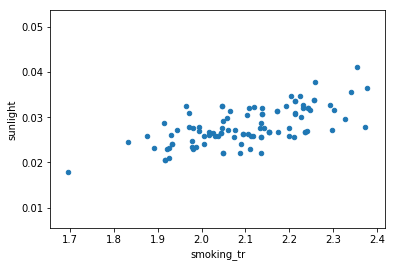

In [114]:
en_cty_nona_df3.plot(x='smoking_tr',y='sunlight',kind='scatter')

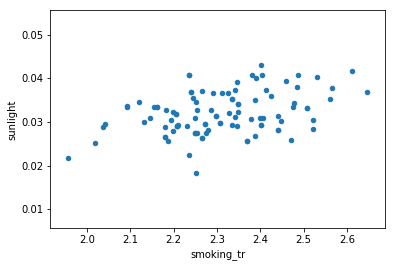

In [115]:
ols_cty_nona_df3.plot(x='smoking_tr',y='sunlight',kind='scatter')

The elastic net results are less noisy, and the counfidng effects are more apparent, but what about the absolute magnitude of the effect?  For that we need quick coefficients.

In [119]:
regr = lm.LinearRegression()
regr.fit(en_cty_nona_df3.smoking_tr.values.reshape(-1,1),en_cty_nona_df3.sunlight.values.reshape(-1,1))
regr.coef_

array([[0.02090357]])

In [120]:
regr = lm.LinearRegression()
regr.fit(ols_cty_nona_df3.smoking_tr.values.reshape(-1,1),ols_cty_nona_df3.sunlight.values.reshape(-1,1))
regr.coef_

array([[0.01350976]])

So, in fact OLS is a bit less confounded... and given that we aren't off by more than 1 or 2, the level is tolerable.  Let's check the other factors quickly... 

In [122]:
corr_df = pd.DataFrame(en_cty_nona_df3.corr())
corr_df

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
smoking_tr,1.000000,0.094308,0.246811,0.234327,-0.388393,0.260467,-0.041715,-0.300189,0.658172
obesity,0.094308,1.000000,0.127130,0.305126,0.134089,0.122255,-0.006156,-0.474940,0.268370
foodenv_tr,0.246811,0.127130,1.000000,0.095549,0.256760,0.155122,-0.113623,0.027804,0.289180
gauss_exercise,0.234327,0.305126,0.095549,1.000000,0.156333,-0.151768,0.113293,0.168379,0.194227
noinsurance_tr,-0.388393,0.134089,0.256760,0.156333,1.000000,0.063114,-0.040706,0.134979,-0.363075
physicians_tr,0.260467,0.122255,0.155122,-0.151768,0.063114,1.000000,0.055336,-0.005689,0.324460
pollution,-0.041715,-0.006156,-0.113623,0.113293,-0.040706,0.055336,1.000000,0.348787,0.067325
diabetes,-0.300189,-0.474940,0.027804,0.168379,0.134979,-0.005689,0.348787,1.000000,-0.171209
sunlight,0.658172,0.268370,0.289180,0.194227,-0.363075,0.324460,0.067325,-0.171209,1.000000


In [124]:
corr_df = pd.DataFrame(ols_cty_nona_df3.corr())
corr_df

,smoking_tr,obesity,foodenv_tr,gauss_exercise,noinsurance_tr,physicians_tr,pollution,diabetes,sunlight
smoking_tr,1.000000,-0.212055,0.454492,-0.152062,0.062307,0.234117,0.074557,-0.362381,0.378268
obesity,-0.212055,1.000000,0.145246,0.389586,0.111713,-0.053881,0.103948,-0.302928,0.423207
foodenv_tr,0.454492,0.145246,1.000000,-0.039335,0.204972,0.087632,0.184262,-0.068998,0.367772
gauss_exercise,-0.152062,0.389586,-0.039335,1.000000,0.133543,-0.503976,0.184762,0.203770,0.076767
noinsurance_tr,0.062307,0.111713,0.204972,0.133543,1.000000,-0.043616,-0.026496,-0.196216,-0.296397
physicians_tr,0.234117,-0.053881,0.087632,-0.503976,-0.043616,1.000000,0.053324,0.098892,0.247903
pollution,0.074557,0.103948,0.184262,0.184762,-0.026496,0.053324,1.000000,0.272110,0.160582
diabetes,-0.362381,-0.302928,-0.068998,0.203770,-0.196216,0.098892,0.272110,1.000000,-0.174835
sunlight,0.378268,0.423207,0.367772,0.076767,-0.296397,0.247903,0.160582,-0.174835,1.000000


In [125]:
corr_df = pd.DataFrame(en_cty_nona_df3.corr())
corr_df.mean()

smoking_tr        0.195976
obesity           0.174465
foodenv_tr        0.231637
gauss_exercise    0.235052
noinsurance_tr    0.105900
physicians_tr     0.202589
pollution         0.153616
diabetes          0.080880
sunlight          0.251939
dtype: float64

In [126]:
corr_df = pd.DataFrame(ols_cty_nona_df3.corr())
corr_df.mean()

smoking_tr        0.164138
obesity           0.178315
foodenv_tr        0.259560
gauss_exercise    0.143673
noinsurance_tr    0.105535
physicians_tr     0.124488
pollution         0.223005
diabetes          0.052157
sunlight          0.242585
dtype: float64

No clear winner, the smoking-sunlight was the worst offender for the elastic net, but the physicians-exercise is worst for ols... show that...

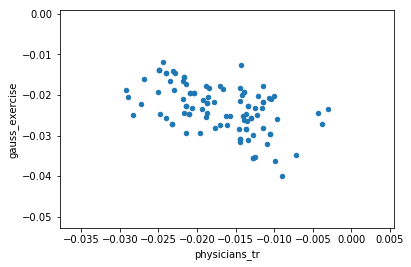

In [127]:
ols_cty_nona_df3.plot(x='physicians_tr',y='gauss_exercise',kind='scatter')

Not so bad ... let's export the risk factors for working with Plotly ...

In [130]:
ols_cty_nona_df3.to_csv('ols_county_only_risks.csv')

In [131]:
en_cty_nona_df3.to_csv('elasticnet_county_only_risks.csv')